<a href="https://colab.research.google.com/github/mlacasa/ProcessMining/blob/main/pm4pyFinancial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Finantial log

https://www.kaggle.com/code/samhomsi/process-mining/data

In [1]:
pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 8.6 MB/s 
     |████████████████████████████████| 40 kB 5.1 MB/s 
     |████████████████████████████████| 748 kB 58.9 MB/s 
     |████████████████████████████████| 1.6 MB 44.5 MB/s 
  Created wheel for pyvis: filename=pyvis-0.3.1-py3-none-any.whl size=755850 sha256=6b278ca40ceae3db5536f028c770e76abac355d377fb837635f0d0ff106b7fa1
  Stored in directory: /root/.cache/pip/wheels/a4/0c/61/8469ca276f96ab772c3acc7f47d71e9737cbdf6f446f017f48
  Created wheel for stringdist: filename=StringDist-1.0.9-cp38-cp38-linux_x86_64.whl size=24201 sha256=a64604fc912032464fd02f1fe62d7eb88eed17154c4f07cc2be3dce8274fadac
  Stored in directory: /root/.cache/pip/wheels/7a/64/e2/16f6a25a62a78f951c1715adb24ba2271ae9d7872f42378c3a
Successfully built pyvis stringdist


In [6]:
import pandas as pd
import pm4py
import numpy as np

In [9]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery



# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [59]:
# Cargamos dos dataset
log = pm4py.read_xes('/content/drive/MyDrive/Colab Notebooks/Mineria Processos/financial_log.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [82]:
log.head()

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-09-30 22:38:44.546000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000


In [60]:
# actividades que comienzan y que acaban

starts = pm4py.stats.get_start_activities(log)
ends = pm4py.stats.get_end_activities(log)

In [61]:
# Actividades de inicio A_SUBMITED comienza 13.087 veces
starts

{'A_SUBMITTED': 13087}

In [62]:
# Actividades que acaban: 11 y sus repeticiones.
ends

{'A_DECLINED': 3429,
 'W_Valideren aanvraag': 2747,
 'W_Afhandelen leads': 2234,
 'W_Completeren aanvraag': 1939,
 'W_Nabellen offertes': 1290,
 'A_CANCELLED': 655,
 'W_Nabellen incomplete dossiers': 452,
 'O_CANCELLED': 279,
 'W_Beoordelen fraude': 57,
 'W_Wijzigen contractgegevens': 4,
 'A_REGISTERED': 1}

In [63]:
# guardamos lasa variantes
variantes = pm4py.get_variants_as_tuples(log)

In [87]:
# Cuántas variantes y cuántos registros?
print('Num variantes: ',len(variantes),' y en num casos: ', len(log['case:concept:name'].unique()))

Num variantes:  4366  y en num casos:  13087


In [79]:
# Variantes, orden por número que se repiten.
# Las primeras 2 variantes, suman unos 5400 casos de los 13000
# La 10a variante, menos del 1% del total (1% = 130)
variantes_df = pd.DataFrame(sorted(variantes.items(), key=lambda x: x[1], reverse=True)[:10], columns = ['variantes', 'repeticiones'])
variantes_df

,variantes,repeticiones
0,"(A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED)",3429
1,"(A_SUBMITTED, A_PARTLYSUBMITTED, W_Afhandelen ...",1872
2,"(A_SUBMITTED, A_PARTLYSUBMITTED, W_Afhandelen ...",271
3,"(A_SUBMITTED, A_PARTLYSUBMITTED, W_Afhandelen ...",209
4,"(A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",160
5,"(A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",134
6,"(A_SUBMITTED, A_PARTLYSUBMITTED, W_Afhandelen ...",126
7,"(A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",93
8,"(A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",87
9,"(A_SUBMITTED, A_PARTLYSUBMITTED, W_Afhandelen ...",74


In [89]:
# Número de casos que representan las 10 variantes más repetidas:
variantes_df['repeticiones'].sum()

6455

In [91]:
# Ahora seleccionamos los registros (filtramos la dataset) pero de otra manera
# Compruebo que el num de casos, es efectivamente, el mismo
len(pm4py.filter_variants_top_k(log, 10)['case:concept:name'].unique())

6455

In [93]:
top = 10 # El top de variantes por repeticiones
variantes_10 = pm4py.filter_variants_top_k(log, top)
variantes_10.head() #Acabamos de filtrar la dataset.


,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
124,112,COMPLETE,A_SUBMITTED,2011-10-01 06:11:08.866000+00:00,2011-10-01 06:11:08.865000+00:00,173697,15000
125,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 06:11:09.035000+00:00,2011-10-01 06:11:08.865000+00:00,173697,15000
126,112,COMPLETE,A_DECLINED,2011-10-01 06:11:46.420000+00:00,2011-10-01 06:11:08.865000+00:00,173697,15000
127,112,COMPLETE,A_SUBMITTED,2011-10-01 06:15:39.894000+00:00,2011-10-01 06:15:39.894000+00:00,173700,5000
128,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 06:15:40.102000+00:00,2011-10-01 06:15:39.894000+00:00,173700,5000


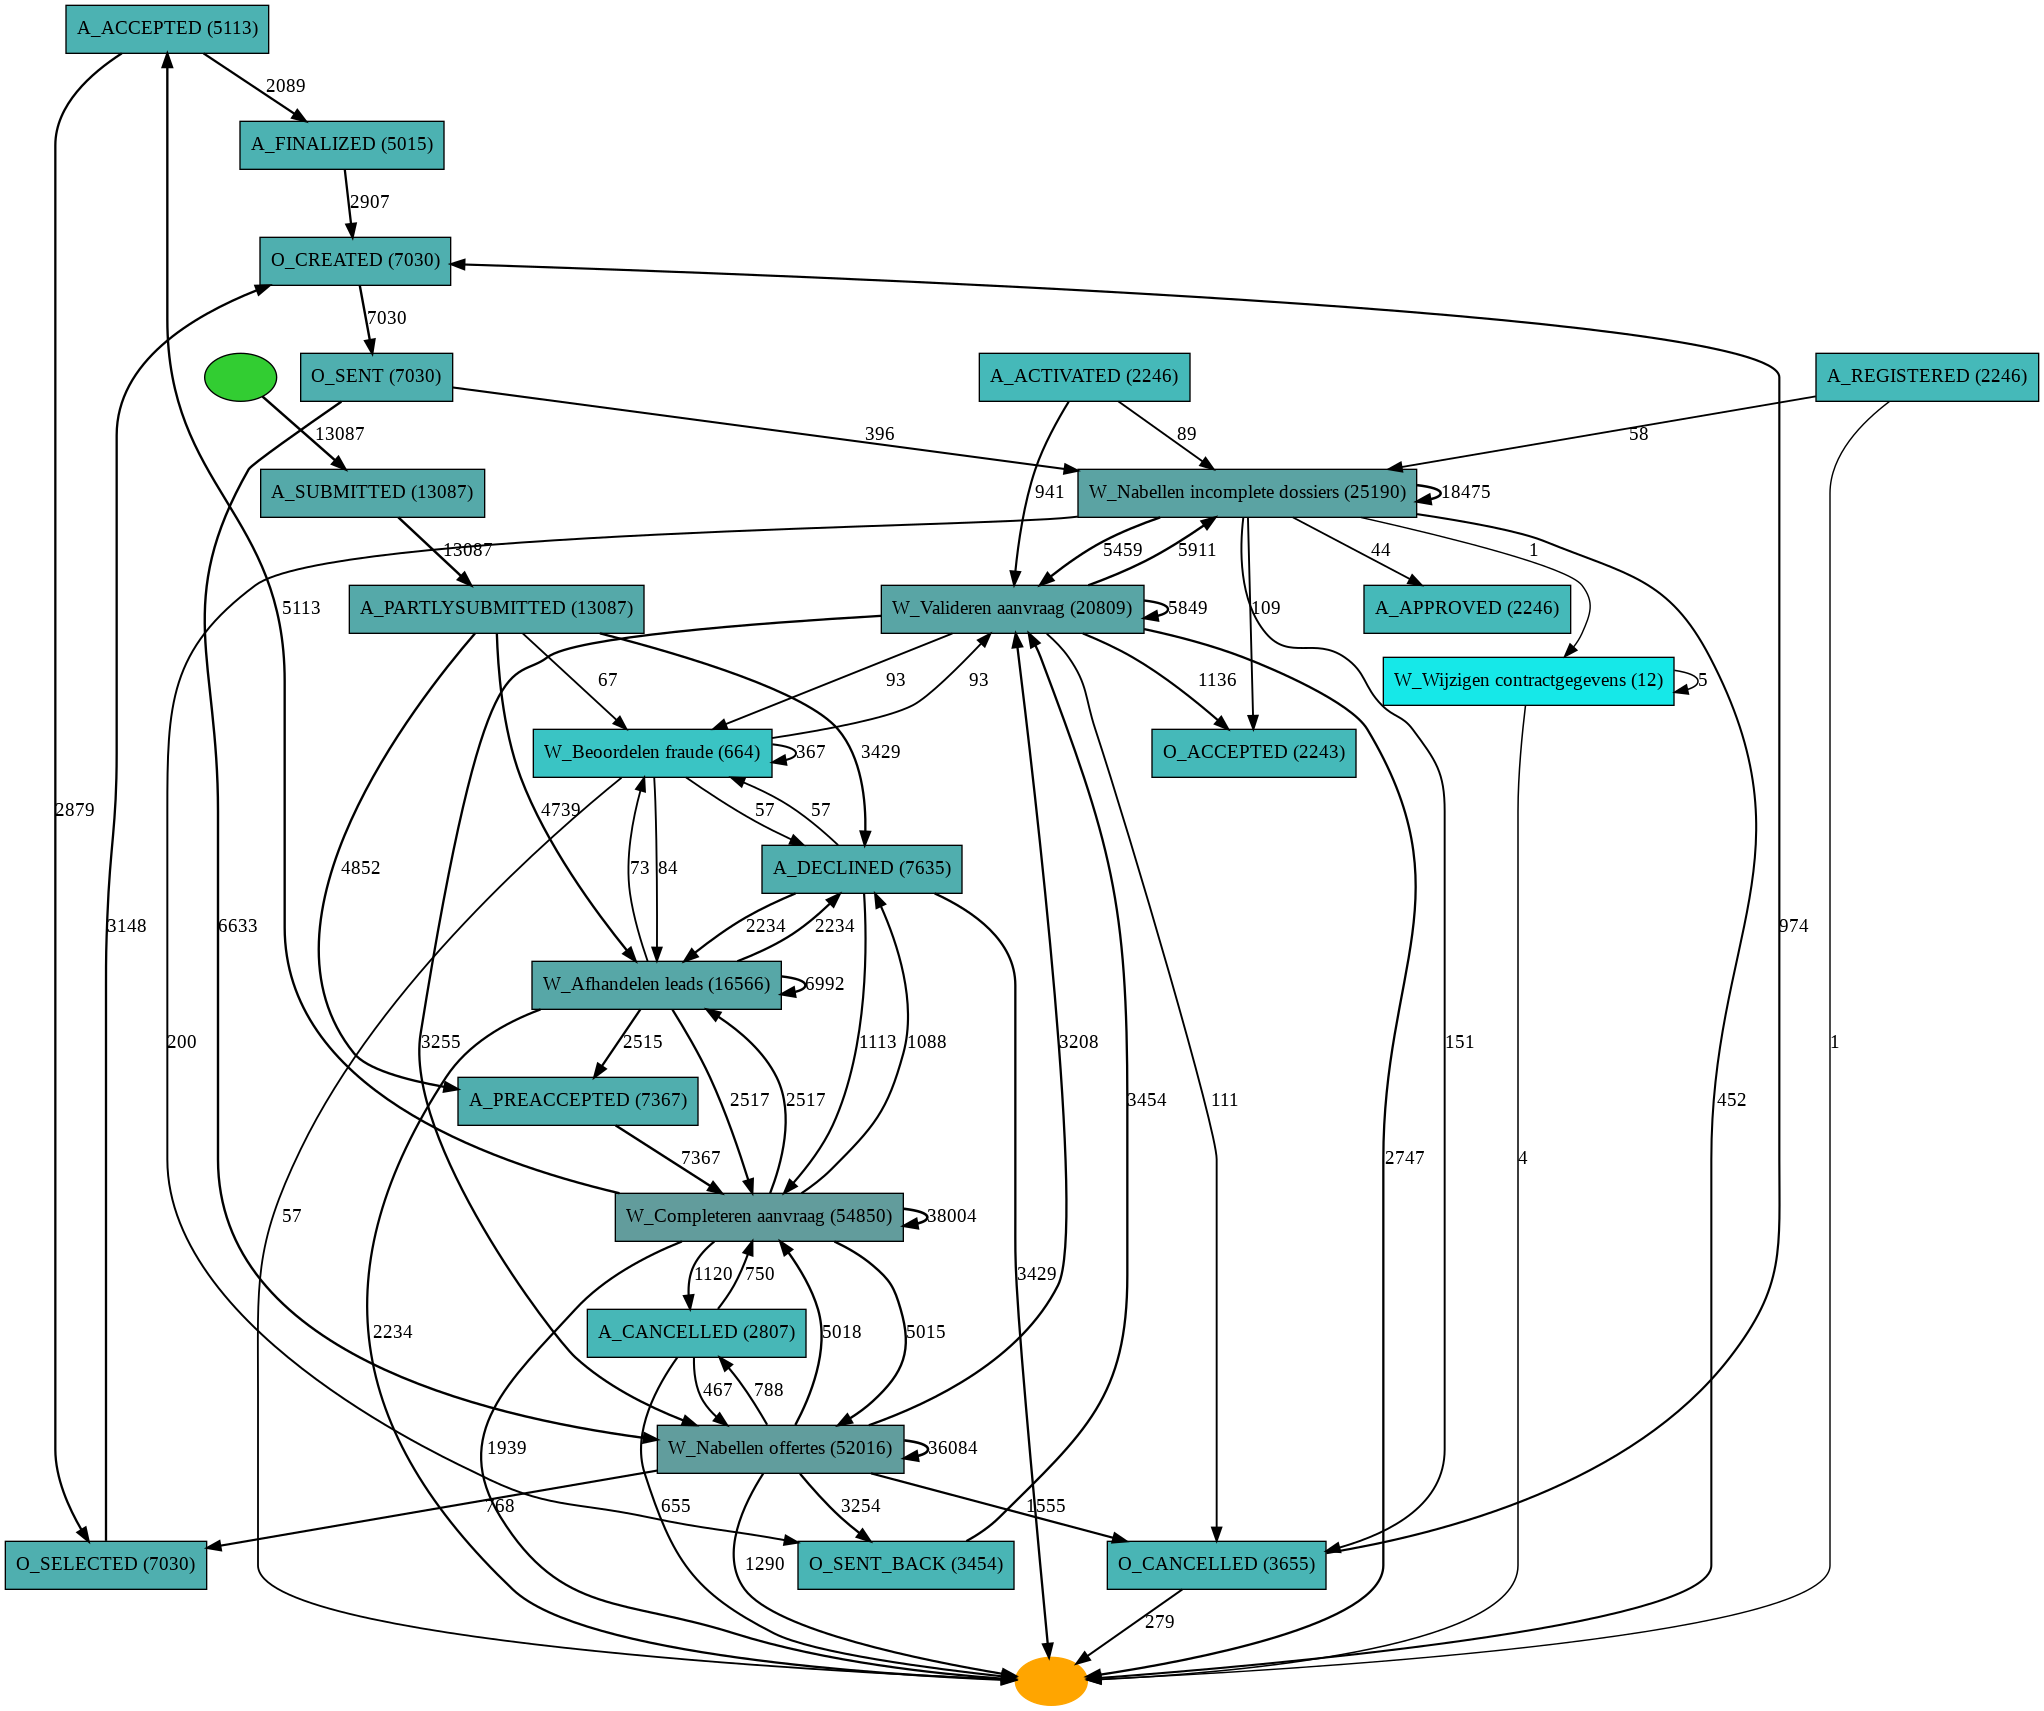

In [94]:
# Grafo dirigido de todos los eventos y variantes
map = pm4py.discover_heuristics_net(log)
pm4py.view_heuristics_net(map)

/usr/local/lib/python3.8/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


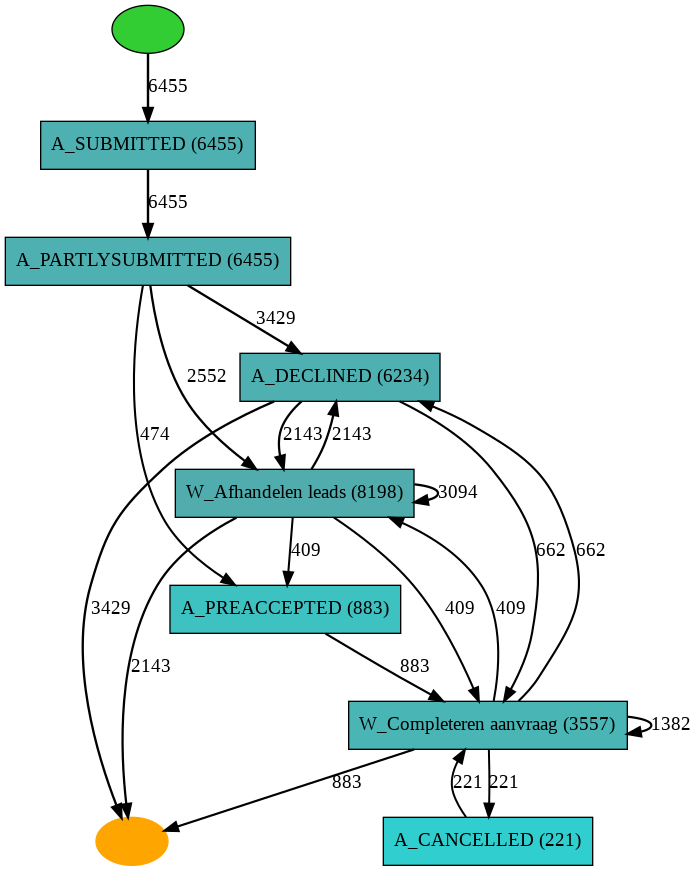

In [95]:
# Grafo dirigido sólo con las 10 variantes más comunes
map = pm4py.discover_heuristics_net(variantes_10)
pm4py.view_heuristics_net(map)

/usr/local/lib/python3.8/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


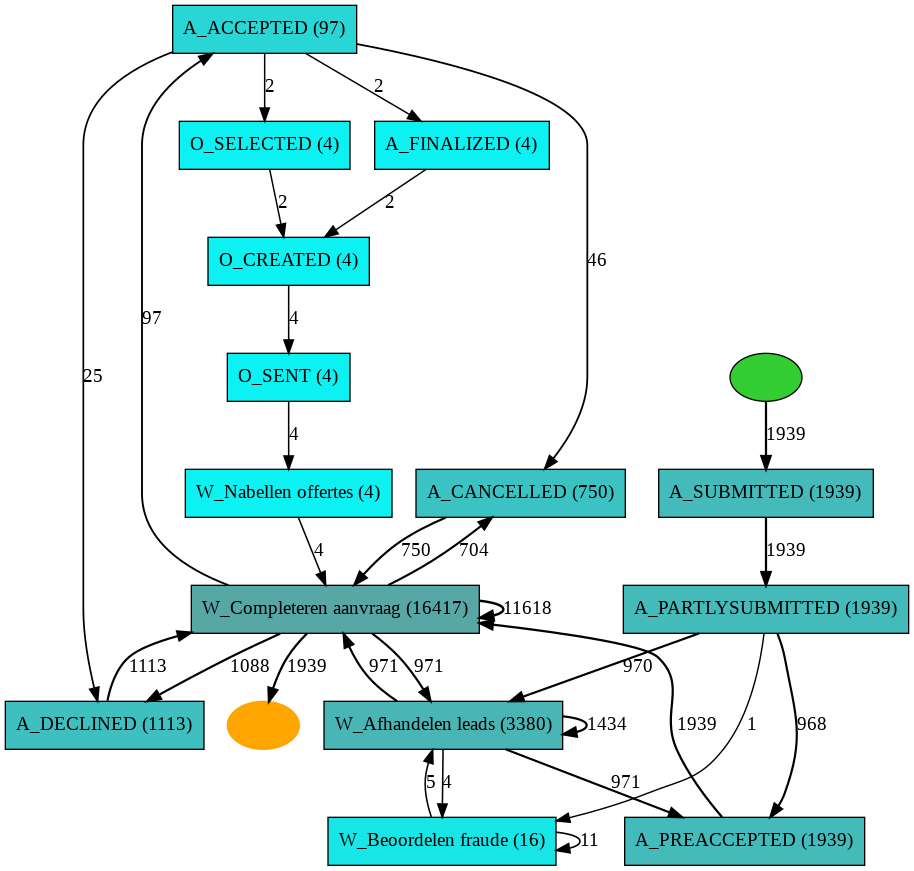

In [99]:
# Filtramos esta vez sólo por eventos que acaben de una determinada manera

completed = pm4py.filter_end_activities(log, ["W_Completeren aanvraag"])
# Grafo dirigido sólo las que acaban con éxito
map = pm4py.discover_heuristics_net(completed)
pm4py.view_heuristics_net(map)